In [24]:
import importlib
import gpudrive
importlib.reload(gpudrive)
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.env.config import EnvConfig, RenderConfig
from gpudrive.env.dataset import SceneDataLoader
import numpy as np
from gpudrive.visualize.utils import img_from_fig
import os
import torch
from pathlib import Path

# Set working directory to the base directory 'gpudrive_madrona'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive_madrona' not found")
os.chdir(working_dir)
import torch
from PIL import Image

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (10, 5)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")
mpl.rcParams["lines.markersize"] = 8

plt.set_loglevel("WARNING")
%matplotlib inline

### Make environment

In [25]:
GUIDANCE_MODE = "log_replay"

env_config = EnvConfig(
    dynamics_model="classic",
    reward_type="guided_autonomy",
    guidance=True,
    guidance_mode=GUIDANCE_MODE,
    add_reference_heading=True,
    add_reference_speed=True,
    add_reference_pos_xy=True,
    init_mode="wosac_train",
)
render_config = RenderConfig()

train_loader = SceneDataLoader(
    root="/home/emerge/gpudrive/data/processed/wosac/validation_json_100",
    batch_size=100,
    dataset_size=100,
    sample_with_replacement=False,
    shuffle=False,
    file_prefix="",
)

env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=64, 
    device="cpu",
)

print(env.data_batch)

obs = env.reset(env.cont_agent_mask)

reference_traj = torch.cat([
    env.reference_trajectory.pos_xy,
    env.reference_trajectory.vel_xy,
    env.reference_trajectory.yaw,
], dim=-1)

# Save as numpy array
reference_traj_np = reference_traj[env.cont_agent_mask].numpy()

np.save(f"reference_{GUIDANCE_MODE}.npy", reference_traj_np)

: 

### Q1. Are the distributions from different modes (`vbd_online`, `log_replay` and `vbd_amortized`) on the same scale?

- Unnormalized values
- Macroscopic (full dist)

In [3]:
# Load npy array from the file
ref_log_replay = np.load("examples/eval/notebooks/reference_log_replay.npy")
ref_vbd_amortized = np.load("examples/eval/notebooks/reference_vbd_amortized.npy")
ref_vbd_online = np.load("examples/eval/notebooks/reference_vbd_online.npy")

In [4]:
# Controlled agent elements for 10 scenarios
ref_log_replay.shape, ref_vbd_amortized.shape, ref_vbd_online.shape

((194, 91, 5), (194, 90, 5), (194, 80, 5))

### Q1 | **Global positions** $(x,y)$

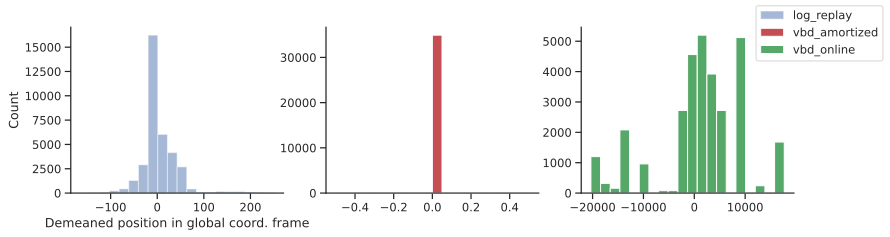

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3),)# sharex=True, sharey=True)

axs[0].hist(ref_log_replay[:, :, :2].flatten(), color='b', alpha=0.5, bins=20, label="log_replay")
axs[1].hist(ref_vbd_amortized[:, :, :2].flatten(), color='r', alpha=1.0, bins=20, label="vbd_amortized")
axs[2].hist(ref_vbd_online[:, :, :2].flatten(), color='g', alpha=1.0, bins=20, label="vbd_online")

axs[0].set_xlabel("Demeaned position in global coord. frame")
axs[0].set_ylabel("Count")

fig.legend()
sns.despine()

### Q1 | **Velocities** $(x,y)$

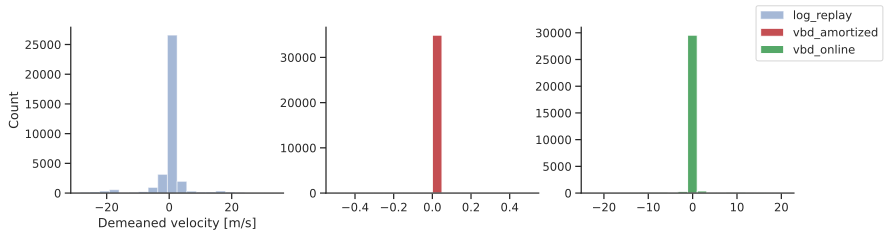

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3),)# sharex=True, sharey=True)

axs[0].hist(ref_log_replay[:, :, 2:4].flatten(), color='b', alpha=0.5, bins=20, label="log_replay")
axs[1].hist(ref_vbd_amortized[:, :, 2:4].flatten(), color='r', alpha=1.0, bins=20, label="vbd_amortized")
axs[2].hist(ref_vbd_online[:, :, 2:4].flatten(), color='g', alpha=1.0, bins=20, label="vbd_online")

axs[0].set_xlabel("Demeaned velocity [m/s]")
axs[0].set_ylabel("Count")

fig.legend()
sns.despine()

### Q1 | **Headings**

In [19]:
ref_log_replay[:, :, 4].max(), ref_vbd_amortized[:, :, 4].max(), ref_vbd_online[:, :, 4].max()

(3.1413903, 0.0, 3.1357126)

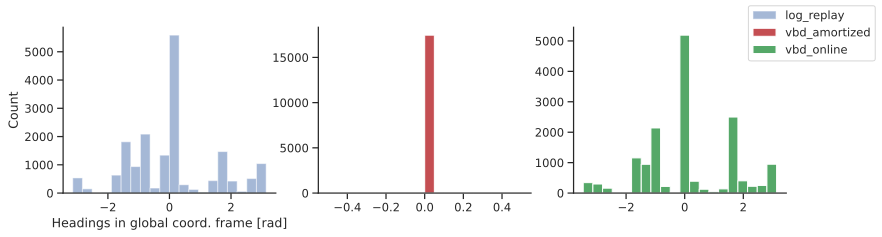

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3),)# sharex=True, sharey=True)

axs[0].hist(ref_log_replay[:, :, 4].flatten(), color='b', alpha=0.5, bins=20, label="log_replay")
axs[1].hist(ref_vbd_amortized[:, :, 4].flatten(), color='r', alpha=1.0, bins=20, label="vbd_amortized")
axs[2].hist(ref_vbd_online[:, :, 4].flatten(), color='g', alpha=1.0, bins=20, label="vbd_online")

axs[0].set_xlabel("Headings in global coord. frame [rad]")
axs[0].set_ylabel("Count")

# add legend
fig.legend()
sns.despine()

### Q2. How do the trajectories differ qualitatively?

- Plot several guidance trajectories for a particular agent to ensure that they are on the same scale

In [ ]:
ref_vbd_amortized[agent_idx, :, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
agent_idx = 0

fig, axs = plt.subplots(1, 3, figsize=(13, 3))
axs[0].plot(ref_log_replay[agent_idx, :, 0], ref_log_replay[agent_idx, :, 1], color='b', alpha=0.5, label="log_replay")
axs[1].plot(ref_vbd_online[agent_idx, :, 0], ref_vbd_online[agent_idx, :, 1], color='b', alpha=0.5, label="vbd_online")
axs[2].plot(ref_vbd_amortized[agent_idx, :, 0], ref_vbd_amortized[agent_idx, :, 1], color='b', alpha=0.5, label="vbd_amortized")

axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

fig.legend();

### Show corresponding full agent views

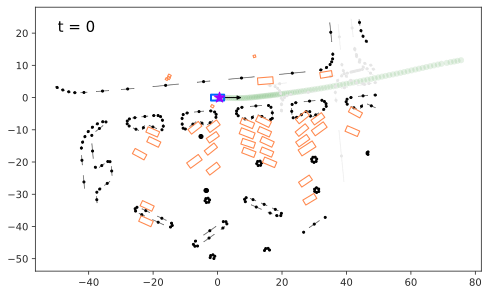

In [ ]:
center_agent_idx=3

traj_masked = env.reference_path[center_agent_idx, :, :]

agent_obs_masked = env.vis.plot_agent_observation(
    env_idx=0,
    agent_idx=center_agent_idx,
    figsize=(8, 8),
    trajectory=traj_masked,
)

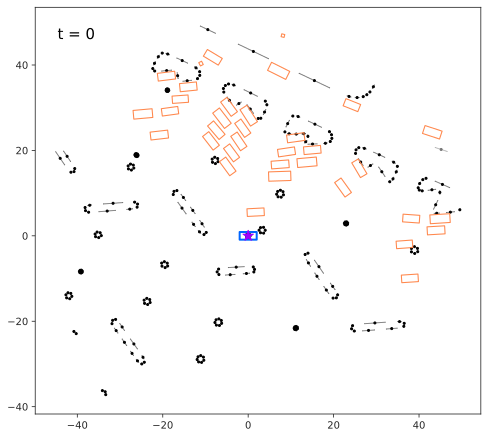

In [ ]:
center_agent_idx=40

traj_masked = env.reference_path[center_agent_idx, :, :]

agent_obs_masked = env.vis.plot_agent_observation(
    env_idx=0,
    agent_idx=center_agent_idx,
    figsize=(8, 8),
    trajectory=traj_masked,
)

### Simulator state centered at that agent

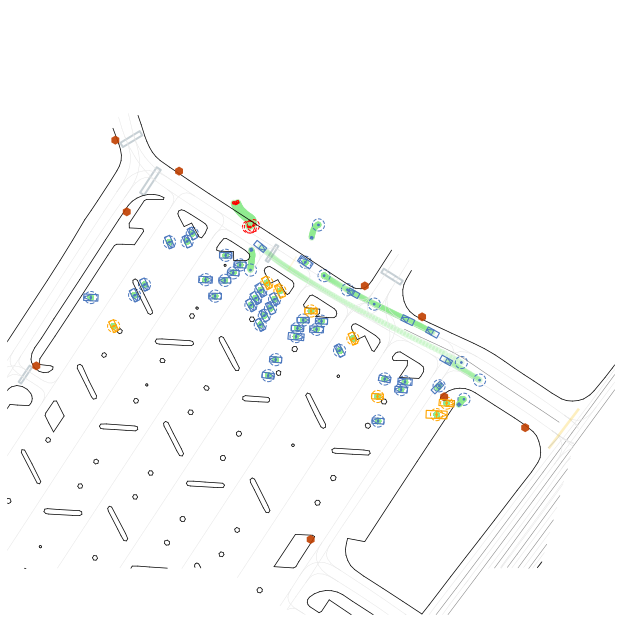

In [9]:
sim_states = env.vis.plot_simulator_state(
    env_indices=env_idx,
    zoom_radius=100,
    plot_guidance_pos_xy=True,
    center_agent_indices=[center_agent_idx],
)
#Image.fromarray(img_from_fig(sim_states[0]))
sim_states[0]

### Useful dataset statistics

- What is the distribution of the guidance trajectories in the dataset?
    - What is the average length $T$?, what is the variance?
- How often is the guidance trajectory to "do nothing"?